# Recommendations with IBM


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Check data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [4]:
# Check df_content information
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

The dictionary and cells below will be used to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  

A visual and descriptive statistics will be provided to assist with giving a look at the number of times each user interacts with an article.  

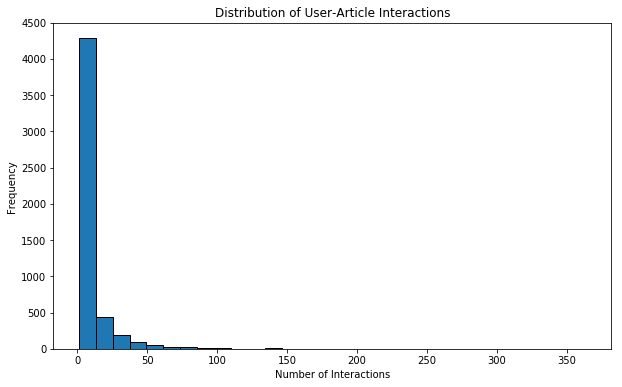

In [5]:
# Calculate the number of article interactions for each user and rename the columns
user_article_interactions = df.groupby('email')['article_id'].count().reset_index()
user_article_interactions.columns = ['email', 'article_interactions']

# Plotting the distribution of user-article interactions
plt.figure(figsize=(10, 6))
plt.hist(user_article_interactions['article_interactions'], bins=30, edgecolor='black')
plt.title('Distribution of User-Article Interactions')
plt.xlabel('Number of Interactions')
plt.ylabel('Frequency')
plt.show()

The plot shows a highly skewed distribution of user-article interactions, with most users having few interactions and a small number of users having many. The majority of users have between 0 and 10 interactions, while a few outliers have up to 350 interactions.

In [6]:
# Descriptive statistics for user-article interactions
user_article_interactions['article_interactions'].describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_interactions, dtype: float64

The dataset contains 5,148 user-article interactions with an average of 8.93 interactions per user. Most users have between 1 and 9 interactions, with a median of 3. There is a high variability (std = 16.80) and a few users with up to 364 interactions.

In [7]:
# Median and maximum number of user-article interactions
median_val = user_article_interactions['article_interactions'].median()
max_views_by_user = user_article_interactions['article_interactions'].max()

print(f"50% of individuals interact with {median_val} number of articles or fewer.")
print(f"The maximum number of user-article interactions by any 1 user is {max_views_by_user}.")

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


In [8]:
# # Fill in the median and maximum number of user_article interactios below

# median_val = # 50% of individuals interact with 3.0 number of articles or fewer.
# max_views_by_user = # The maximum number of user-article interactions by any 1 user is 364.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [9]:
# Find duplicate articles
duplicate_articles = df_content[df_content.duplicated(subset=['article_id'], keep=False)]

In [10]:
# Display the duplicate articles
print(f"Number of duplicate articles: {duplicate_articles.shape[0]}")
print("Some examples of duplicate articles:")
duplicate_articles.head(10)

Number of duplicate articles: 10
Some examples of duplicate articles:


,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [11]:
# Explore how many unique article_ids are duplicated
duplicate_counts = duplicate_articles['article_id'].value_counts()
print(f"Number of unique article_ids with duplicates: {duplicate_counts.shape[0]}")
print("Top 5 article_ids with the most duplicates:")
duplicate_counts.head(5)

Number of unique article_ids with duplicates: 5
Top 5 article_ids with the most duplicates:


398    2
221    2
232    2
50     2
577    2
Name: article_id, dtype: int64

In [12]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)

In [13]:
# Check the number of unique articles
unique_articles = df_content['article_id'].nunique()
print(f"The number of unique articles in df_content is {unique_articles}.")

The number of unique articles in df_content is 1051.


`3.` The cells below will be used to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [14]:
# The number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique()

# The number of unique articles on the IBM platform
total_articles = df_content['article_id'].nunique()

# The number of unique users
unique_users = df['email'].nunique()

# The number of user-article interactions
user_article_interactions = df.shape[0]

In [15]:
# Print the values
print(f"The number of unique articles that have at least one interaction: {unique_articles}")
print(f"The number of unique articles on the IBM platform: {total_articles}")
print(f"The number of unique users: {unique_users}")
print(f"The number of user-article interactions: {user_article_interactions}")

The number of unique articles that have at least one interaction: 714
The number of unique articles on the IBM platform: 1051
The number of unique users: 5148
The number of user-article interactions: 45993


`4.` The cells below will be used to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
# Ensure 'article_id' is treated as a string
df['article_id'] = df['article_id'].astype(str)

# Find the most viewed article and the number of views
most_viewed_article_id = df['article_id'].value_counts().idxmax() # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df['article_id'].value_counts().max() # The most viewed article in the dataset was viewed how many times?

In [17]:
# Print the result
print(f"The most viewed article in the dataset is {most_viewed_article_id} with {max_views} views.")

The most viewed article in the dataset is 1429.0 with 937 views.


In [18]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
## Tests

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` The function below will return the **n** top articles ordered with most interactions as the top.

In [20]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['title'].value_counts().head(n).index.tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['article_id'].value_counts().head(n).index.astype(str).tolist()
 
    return top_articles # Return the top article ids

In [21]:
# Print the top 10 articles and the top 10 article IDs
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [22]:
# Test the function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` The function below will reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** will only appear in each **row** once.


* Each **article** will only show up in one **column**.  


* **If a user has interacted with an article, then a 1 is placed where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article will be a 1.  


* **If a user has not interacted with an item, then a zero is placed where the user-row meets for that article-column**.

In [23]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id', 'article_id'])['title'].max().unstack().notnull().astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [24]:
## Tests
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` The function below will take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result will contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.

In [25]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    similarity = user_item.dot(user_item.loc[user_id]) # compute similarity of each user to the provided user

    similarity = similarity.sort_values(ascending=False) # sort by similarity

    most_similar_users = similarity.index.tolist() # create list of just the ids
   
    most_similar_users.remove(user_id) # remove the own user's id
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [26]:
# Do a spot check of the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that we have a function that provides the most similar users to each user, we will want to use these users to find articles we can recommend. The functions below will return the articles we would recommend to each user.

In [27]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(str).tolist()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    similar_users = find_similar_users(user_id)
    
    user_articles, _ = get_user_articles(user_id)
    
    for sim_user in similar_users:
        sim_user_articles, _ = get_user_articles(sim_user)
        
        for article in sim_user_articles:
            if article not in user_articles:
                recs.append(article)
                if len(recs) >= m:
                    return recs
                
    return recs # return your recommendations for this user_id

In [28]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

In [29]:
# Test the functions
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user, we would choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we would choose articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the **top_articles** function we wrote earlier.

In [30]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Compute similarity with other users
    similarity = np.dot(user_item.loc[user_id], user_item.T)
    
    # Create a dataframe for similarity and number of interactions
    neighbors_df = pd.DataFrame({
        'neighbor_id': user_item.index,
        'similarity': similarity,
        'num_interactions': df.groupby('user_id').size()
    })
    
    # Sort dataframe by similarity and number of interactions
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    # Remove the input user from the dataframe
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Find similar users
    similar_users = get_top_sorted_users(user_id)
    
    # Get articles the user has interacted with
    user_articles = set(get_user_articles(user_id)[0])
    
    # Initialize recommendations list
    recs = []
    
    # Loop through similar users and find recommendations
    for neighbor_id in similar_users['neighbor_id']:
        neighbor_articles = set(get_user_articles(neighbor_id)[0])
        # Find articles the neighbor has interacted with but the user hasn't
        new_recs = neighbor_articles - user_articles
        # Sort new recommendations by total interactions
        sorted_recs = df[df['article_id'].isin(new_recs)].groupby('article_id').size().sort_values(ascending=False).index.tolist()
        # Add sorted recommendations to the list
        recs.extend(sorted_recs)
        # Remove already recommended articles
        user_articles = user_articles.union(new_recs)
        # Check if enough recommendations are found
        if len(recs) >= m:
            break
    
    # Select only the top m recommendations
    recs = recs[:m]
    
    # Get article names for recommendations
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [31]:
# Quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` We would use the functions from above to correctly fill in the solutions to the dictionary below.  Then test the dictionary against the solution. We would provide the code we need to answer each following the comments below.

In [32]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id'] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9]['neighbor_id'] # Find the 10th most similar user to user 131

In [33]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Method for new users**
- A better way to make recommendations for a new user would be to use rank-based recommendations, such as recommending the most popular articles.

`7.` Using the existing functions, we would provide the top 10 recommended articles we would provide for a new user below.

In [34]:
new_user = '0.0'

# As a new user, they have no observed articles.
# Recommend a list of the top 10 article ids
new_user_recs = get_top_article_ids(10)

In [35]:
# Test

assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, we will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` Since we have already created a **user_item** matrix above in **question 1** of **Part III** above, the first thing to be done is to run the cells to get things set up for the rest of this **Part IV** of the notebook.

In [36]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [37]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, we can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  We will use the cell below to perform SVD.

In [38]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  We will run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

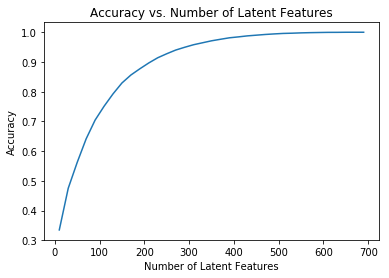

In [39]:
# Create an array of number of latent features ranging from 10 to 700, inclusive, with a step of 20
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

- It's evident that accuracy increases as the number of latent features increases.

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

We will use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [40]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [41]:
# Count of users in the test set who are also in the training set (i.e., we can make predictions for them)
a = len(set(test_idx) & set(user_item_train.index))

# Count of users in the test set who are not in the training set (i.e., cold start problem for these users)
b = len(set(test_idx) - set(user_item_train.index))

# Count of articles in the test set that are also in the training set (i.e., we can make predictions for them)
c = len(set(test_arts) & set(user_item_train.columns))

# Count of articles in the test set that are not in the training set (i.e., cold start problem for these articles)
d = len(set(test_arts) - set(user_item_train.columns))

# Print the outputs with descriptive text
print(f'Number of users we can make predictions for in the test set: {a}')
print(f'Number of users in the test set we are not able to make predictions for (cold start problem): {b}')
print(f'Number of articles we can make predictions for in the test set: {c}')
print(f'Number of articles in the test set we are not able to make predictions for (cold start problem): {d}')

Number of users we can make predictions for in the test set: 20
Number of users in the test set we are not able to make predictions for (cold start problem): 662
Number of articles we can make predictions for in the test set: 574
Number of articles in the test set we are not able to make predictions for (cold start problem): 0


In [42]:
# Tests

# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?': b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` We will now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then we will find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

We will use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [43]:
# Perform SVD on the User-Item Train Matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)

In [44]:
# Subset the rows and columns for the test set that are also in the training set
test_idx_overlap = list(set(user_item_test.index) & set(user_item_train.index))
test_arts_overlap = list(set(user_item_test.columns) & set(user_item_train.columns))

user_item_test_overlap = user_item_test.loc[test_idx_overlap, test_arts_overlap]

In [45]:
# Decomposition matrices for the overlapping rows and columns
u_test = u_train[user_item_train.index.isin(test_idx_overlap), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts_overlap)]

# Iterate through different numbers of latent features and compute accuracy
num_latent_feats = np.arange(10, 700 + 10, 20)
sum_errs_test = []

for k in num_latent_feats:
    # Restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_test[:, :k], vt_test[:k, :]
    
    # Take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # Compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_overlap, user_item_est)
    
    # Total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs_test.append(err)

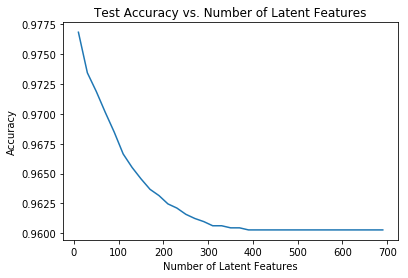

In [46]:
# Plot the accuracy vs. number of latent features
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test) / user_item_test_overlap.size)
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs. Number of Latent Features')
plt.show()

- The plot shows that as the number of latent features rises, accuracy declines. Initially, the accuracy declines dramatically, but then it begins to level out. This shows that incorporating more latent features produces more noise than meaningful information, resulting in poor test performance.

`6.` We will use the cell below to comment on the results we found in the previous question. Given the circumstances of our results, we will discuss what we might do to determine if the recommendations we make with any of the above recommendation systems are an improvement to how users currently find articles?

**Comments**

The findings suggest that although the recommendation algorithm does a good job of predicting articles, the cold start issue causes serious problems when it comes to new or inactive users. Resolving this issue is crucial to raising the recommendation system's general efficacy and user satisfaction. Overcoming these obstacles and improving the system's effectiveness may be accomplished by putting measures in place to collect additional user data and by utilizing sophisticated recommendation algorithms.

Concerning what I would do to determine if the recommendations I make with any of the above recommendation systems are an improvement to how users currently find articles, I would explore A/B testing, user engagement analysis, feedback loop, personalization metrics etc. Implementing these methodologies allows me to objectively determine if the recommendation systems are performing effectively. This holistic method guarantees that the review is thorough, taking into consideration both quantitative measurements and qualitative comments.

## Create a .html version of this notebook

In [47]:
# Create a .html version of this notebook
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0